# Background Stuff
Explain what we are doing here

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import resample

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RNN
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [2]:
TRAIN_PATH = 'data/train'
TEST_PATH = 'data/test'
SEED = 2018

In [9]:
def get_x_y(file_path):
    files = {}
    files['pos'] = glob(os.path.join(file_path, 'pos', '*.txt'))
    files['neg'] = glob(os.path.join(file_path, 'neg', '*.txt'))
    sentiment_map = {'pos': 1, 'neg': 0}
    x = []
    y = []
    for sentiment in files:
        for file_name in files[sentiment]:
            temp_ = []
            with open(file_name) as file_:
                temp_ = file_.read()
            x.append(temp_)
            y.append(sentiment_map[sentiment])
    return x, y

# Read in the text data - this does not change so can/should be outside the function for speed
x_train_raw, y_train_raw = get_x_y(TRAIN_PATH)
x_test_raw, y_test_raw = get_x_y(TEST_PATH)

def prep_data(vocab_size=100, max_review_len=150):
    time_start = datetime.now()
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(x_train_raw)
    
    # Fit our training data
    x_train_sequence = tokenizer.texts_to_sequences(x_train_raw)
    x_train_pad = pad_sequences(x_train_sequence, maxlen=max_review_len)

    # Fit our testing data
    x_test_sequence = tokenizer.texts_to_sequences(x_test_raw)
    x_test_pad = pad_sequences(x_test_sequence, maxlen=max_review_len)

    # Subset for testing
    x_train_pad_sub, y_train_sub = resample(x_train_pad, y_train_raw, replace=False, n_samples=5000, random_state=SEED)
    x_test_pad_sub, y_test_sub = resample(x_test_pad, y_test_raw, replace=False, n_samples=5000, random_state=SEED)
    
    return x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub

def basic_lstm_model(
    embedding_vector_length=32,
    dropout_rate=0.2, 
    vocab_size=100, 
    max_review_len=150,
    lstm_len=100
):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_len))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_len))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_and_evaluate_model(
    x_train,
    y_train,
    x_test,
    y_test,
    num_epochs=5,
    batch_size=32,
    max_review_len=100,
    embed_length=32,
    vocab_size=100,
    verbose=1
):
    time_start = datetime.now()
    model = basic_lstm_model(
        vocab_size=vocab_size,
        embedding_vector_length=embed_length,
        max_review_len=max_review_len
    )
    model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=verbose)
    scores = model.evaluate(x_test, y_test)
    print("Accuracy: " + str(scores[1]*100) + ' in ' + str(datetime.now() - time_start))
#     print("Accuracy: %.2f%% in %.2s%seconds" % (scores[1]*100, str(datetime.now() - time_start)))
    return scores[1]

In [16]:
max_review_lengths = [5, 10, 25, 50, 100, 150, 200, 250]
vocab_sizes = [10, 50, 100] #, 150, 250, 500]
scores = {}

for vocab_size in vocab_sizes:
    scores[vocab_size] = []
    for max_review in max_review_lengths:
        x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
            vocab_size=vocab_size,
            max_review_len=max_review
        )
    
        scores[vocab_size].append(
            train_and_evaluate_model(
                x_train=x_train_pad_sub,
                y_train=y_train_sub,
                x_test=x_test_pad_sub,
                y_test=y_test_sub,
                num_epochs=2,
                max_review_len=max_review,
                verbose=0
            )
        )

5000/5000 [==============================] - 1s 212us/step
Accuracy: 53.04 in 0:00:07.326499
5000/5000 [==============================] - 1s 275us/step
Accuracy: 55.42 in 0:00:09.191109
5000/5000 [==============================] - 2s 416us/step
Accuracy: 56.98 in 0:00:14.524205
5000/5000 [==============================] - 3s 599us/step
Accuracy: 56.44 in 0:00:23.331589
5000/5000 [==============================] - 5s 968us/step
Accuracy: 55.96 in 0:00:42.646821
5000/5000 [==============================] - 7s 1ms/step
Accuracy: 56.86 in 0:01:00.274194
5000/5000 [==============================] - 8s 2ms/step
Accuracy: 56.26 in 0:01:18.973855
5000/5000 [==============================] - 10s 2ms/step
Accuracy: 55.120000000000005 in 0:01:37.058194
5000/5000 [==============================] - 1s 263us/step
Accuracy: 54.82 in 0:00:08.095401
5000/5000 [==============================] - 2s 323us/step
Accuracy: 57.220000000000006 in 0:00:10.109848
5000/5000 [==============================] - 2s 4

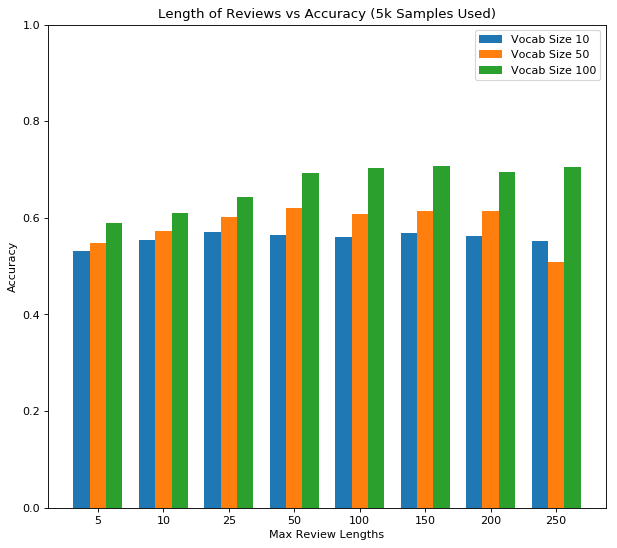

In [33]:
fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
x_range = np.arange(len(next(iter(scores.values()))))
width = 0.25
legend_values = []

for counter, vocab_size in enumerate(scores):
    plt.bar(x_range + width*(counter - 1), scores[vocab_size], width)
    legend_values.append('Vocab Size ' + str(vocab_size))
    
plt.xticks(x_range, max_review_lengths)
plt.ylim([0, 1])
plt.xlabel('Max Review Lengths')
plt.ylabel('Accuracy')
plt.title('Length of Reviews vs Accuracy (5k Samples Used)')
plt.legend(legend_values)

plt.show()

In [ ]:
max_review_lengths = [5, 10, 25, 50, 100, 150, 200, 250]
vocab_sizes = [10, 50, 100] #, 150, 250, 500]
scores = {}

for vocab_size in vocab_sizes:
    scores[vocab_size] = []
    for max_review in max_review_lengths:
        x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
            vocab_size=vocab_size,
            max_review_len=max_review
        )
    
        scores[vocab_size].append(
            train_and_evaluate_model(
                x_train=x_train_pad_sub,
                y_train=y_train_sub,
                x_test=x_test_pad_sub,
                y_test=y_test_sub,
                num_epochs=2,
                max_review_len=max_review,
                verbose=0
            )
        )